[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/enigma-brain/polars_workshop_2025/blob/main/polars.ipynb)

# Polars Intro Workshop

## Learning objectives
- why is Enigma using Polars now? 
- understand advantages of Polars, basics of syntax, what's possible

## Why Polars

We're switching data stacks: MySQL + DataJoint -> Delta Lake tables + Polars. Several tools can analyze Delta Lake tables, but Polars offers a good balance of [performance](https://pola.rs/posts/benchmarks/) and simplicity.

Orcapod uses Polars.

Generally useful if you're working with 2D tables.

Gaining [popularity](https://www.linkedin.com/posts/jeroenjanssens_polars-just-passed-30k-stars-on-github-congratulations-activity-7256626437082746880-fguS/).

## Special features of Polars

#### Performance and memory
- Columnar architecture
    - stores and processes data by column rather than by row
- Parallelism by default 
- Lazy API
    - queries aren't immediately executed; Polars optimizes the entire plan first
- Streaming
    - process datasets larger than available RAM by working in chunks

## Core features for data manipulation

Understanding these is most of the work. Extending to Lazy API and streaming is trivial.

#### Data I/O
- python objects: dict of lists, Pandas DataFrame
- CSV, Excel, Parquet
- Databases
- Delta Lake tables
- Cloud storage
- others ([Docs](https://docs.pola.rs/user-guide/io/), [API reference](https://docs.pola.rs/api/python/dev/reference/io.html))

#### Single table
- `filter` and `select`: filter rows and select columns
- `with_columns`: create new columns based on values in other columns
- `group_by` and `agg`: group data and compute stats
- `pivot` and `unpivot`: convert between long and wide format

#### Multi table
- `join` and `concat`: join and concatenation

## Limitations
- newer: smaller community, fewer tutorials
- it's compared to Pandas, but the syntax is pretty different (although quite clear)


In [8]:
# !pip install palmerpenguins
import palmerpenguins as pp
import polars as pl
pl.Config.set_fmt_str_lengths(100) # nice for displaying longer strings and not truncate them

df = pl.from_pandas(pp.load_penguins())


## Get basic understanding of data
- `head`, `tail`
- `schema`
- `glimpse`
- `sample`

In [3]:
# df
# df.head()
# df.tail()
# df.glimpse() # good for wide DFs
# df.schema
# df.describe()
# df.sample(3)

# Data manipulation/querying

Assuming we have a dataframe called `df`, using Polars generally involves the format:
```
df.context(expression)
```
where the 'context' can be one of the following:

- `select`
- `with_columns`
- `filter`
- `group_by` and `agg`

## `select` columns

In [4]:
# grab a column
df.select("body_mass_g")

# also grabs the same column, but you can do downstream operations this way
df.select(pl.col("body_mass_g"))

# e.g. can sort and do arithmetic, 
df.select(pl.col("body_mass_g").sort() / 1000)

# but further operations require enclosing in parentheses, e.g. renaming the column
df.select(
    (pl.col("body_mass_g")
     .sort() 
     / 1000)
     .alias("body_mass_kg")
) 

# using a 'named expression'
df.select(
    body_mass_kg = (pl.col("body_mass_g")
     .sort() 
     / 1000)
) 

# alias method nice for storing expressions in variables  
kg_expr = ((pl.col("body_mass_g").sort() / 1000).alias("body_mass_kg"))
df.select(kg_expr)

# select multiple columns
df.select(
    (pl.col("species"), pl.col("island")) # or ["species", "island"]
).unique().sort(by="species")


species,island
str,str
"""Adelie""","""Biscoe"""
"""Adelie""","""Dream"""
"""Adelie""","""Torgersen"""
"""Chinstrap""","""Dream"""
"""Gentoo""","""Biscoe"""


There are tons of methods to use within expressions (like `.sort`) that can be used in expressions. See [here](https://docs.pola.rs/api/python/stable/reference/expressions/index.html) for a full list.

Problem: using `select`, create a column that computes the z score (normalized deviations from the mean) for body mass, and name this column "body_mass_zscore"

In [5]:
# expressions support broadcasting
kg_expr = ((pl.col("body_mass_g") - pl.col("body_mass_g").mean()) / pl.col("body_mass_g").std()).alias("body_mass_zscore")
df.select(kg_expr)

body_mass_zscore
f64
-0.563317
-0.500969
-1.186793
null
-0.937403
…
-0.251578
-0.99975
-0.532143


## `with_columns` to add columns

In [10]:
kg_expr = (pl.col("body_mass_g") / 1000).alias("body_mass_kg")
swim_score_expr = (pl.col("flipper_length_mm") / pl.col("body_mass_kg")).alias("swim_score")

# Polars executes expressions in the same context in parallel, so the first option won't work
# df.with_columns(
#     kg_expr,
#     swim_score_expr
# )

# Columns must be creted in serial, by using `with_columns` context twice
df = df.with_columns(
    kg_expr,
).with_columns(
    swim_score_expr,
)
df

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,body_mass_kg,swim_score
str,str,f64,f64,f64,f64,str,i64,f64,f64
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""male""",2007,3.75,48.266667
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""female""",2007,3.8,48.947368
"""Adelie""","""Torgersen""",40.3,18.0,195.0,3250.0,"""female""",2007,3.25,60.0
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null,null
"""Adelie""","""Torgersen""",36.7,19.3,193.0,3450.0,"""female""",2007,3.45,55.942029
…,…,…,…,…,…,…,…,…,…
"""Chinstrap""","""Dream""",55.8,19.8,207.0,4000.0,"""male""",2009,4.0,51.75
"""Chinstrap""","""Dream""",43.5,18.1,202.0,3400.0,"""female""",2009,3.4,59.411765
"""Chinstrap""","""Dream""",49.6,18.2,193.0,3775.0,"""male""",2009,3.775,51.125828


## `filter` rows

In [11]:
df.filter(pl.col("species") == "Gentoo")

# filter based on multiple conditions
(
    df.filter(
    (pl.col("species") == "Adelie") & (pl.col("island") == "Biscoe") 
    )
)

## can use commas instead of ampersands, but not 'and'!
(
    df.filter(
    (pl.col("species") == "Adelie"), 
    (pl.col("island") == "Biscoe"),
    )
)

# in addition to storing expressions as variables to keep things organized, you can also define functions to create expressions
def filter_species_island_expr(species, island):
    return (
        pl.col("species") == species,
        pl.col("island") == island
    )

df.filter(
    filter_species_island_expr("Adelie", "Biscoe")
    )

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,body_mass_kg,swim_score
str,str,f64,f64,f64,f64,str,i64,f64,f64
"""Adelie""","""Biscoe""",37.8,18.3,174.0,3400.0,"""female""",2007,3.4,51.176471
"""Adelie""","""Biscoe""",37.7,18.7,180.0,3600.0,"""male""",2007,3.6,50.0
"""Adelie""","""Biscoe""",35.9,19.2,189.0,3800.0,"""female""",2007,3.8,49.736842
"""Adelie""","""Biscoe""",38.2,18.1,185.0,3950.0,"""male""",2007,3.95,46.835443
"""Adelie""","""Biscoe""",38.8,17.2,180.0,3800.0,"""male""",2007,3.8,47.368421
…,…,…,…,…,…,…,…,…,…
"""Adelie""","""Biscoe""",45.6,20.3,191.0,4600.0,"""male""",2009,4.6,41.521739
"""Adelie""","""Biscoe""",39.7,17.7,193.0,3200.0,"""female""",2009,3.2,60.3125
"""Adelie""","""Biscoe""",42.2,19.5,197.0,4275.0,"""male""",2009,4.275,46.081871


Contexts can be chained together using:
```
df.context1(expression1).context2(expression2)
```

Problem 1: Find the Chinstrap penguin with the largest swim_score. Return just the swim_score

Problem 2: Find the sex of the Chinstrap penguin with the largest swim score. Return just the sex. 

In [ ]:
df.filter(pl.col("species") == "Chinstrap").select(pl.col("swim_score").max().alias("max_swim_score"))

max_swim_score
f64
71.111111


In [ ]:
(
df.select(pl.col(["species", "sex", "swim_score"]))
.filter(pl.col("species") == "Chinstrap")
.sort(by="swim_score", descending=True)
.head(1)
.select(pl.col("sex"))
)

sex
str
"""female"""


## `groupby` and `agg` to group rows by their values, compute statistics

In [ ]:
df.group_by("species").agg(
    pl.col("body_mass_kg").mean(),
    pl.col("swim_score").mean(),
).sort(by="species")

# group by multiple columns, rename the columns
df.group_by(["species", "sex"]).agg(
    pl.col("body_mass_kg").mean().alias("mean_body_mass_g"),
    pl.col("swim_score").mean().alias("mean_swim_score"),
).sort(by="species")

# drop nulls
(
    df
    .drop_nulls(subset = ["sex"])
    .group_by(["species", "sex"])
    .agg(
        pl.col("body_mass_kg").mean().alias("mean_body_mass_kg"),
        pl.col("swim_score").mean().alias("mean_swim_score"),
        pl.len().alias("count") # count the number of rows in each group
    )
    .sort(by="species")
)

# 'expression expansions' help remove redundant code
(
    df
    .drop_nulls(subset = ["sex"])
    .group_by(["species", "sex"])
    .agg(
        pl.col("body_mass_kg", "swim_score").mean().name.prefix("mean_"), # can also use .name.suffix("_mean")
        pl.len().alias("count")
    )
    .sort(by="species")
)

species,sex,body_mass_kgmean_,swim_scoremean_,count
str,str,f64,f64,u32
"""Adelie""","""female""",3.368836,56.067969,73
"""Adelie""","""male""",4.043493,47.880679,73
"""Chinstrap""","""female""",3.527206,54.700678,34
"""Chinstrap""","""male""",3.938971,51.076667,34
"""Gentoo""","""female""",4.679741,45.594384,58
"""Gentoo""","""male""",5.484836,40.502094,61


Problem: use the .quantile method to compute the 0.25, 0.5, and 0.75 quantile per species. Name these columns "q1_swim_score", "q2_swim_score", etc.
Bonus if you can avoid having .quantile in your code

In [ ]:
df.group_by(["species"]).agg(
        pl.col("swim_score").quantile(0.25).alias("q1_swim_score"),
        pl.col("swim_score").quantile(0.5).alias("q2_swim_score"),
        pl.col("swim_score").quantile(0.75).alias("q3_swim_score"),
    )

# more clever but less explicit
df.group_by("species").agg([
    pl.col("swim_score").quantile(q).alias(f"q{i}_swim_score") 
    for i, q in enumerate([0.25, 0.5, 0.75], 1)
])

species,q1_swim_score,q2_swim_score,q3_swim_score
str,f64,f64,f64
"""Gentoo""",40.566038,43.2,45.473684
"""Chinstrap""",50.25641,52.631579,55.072464
"""Adelie""",47.848101,51.543624,56.521739


# Pivots: wide format <-> long format

"Wide" tables have a column for each variable. "Long" tables have fewer columns, with a single column for variable type and another for the corresponding value.

- `.pivot()` : long -> wide
- `.unpivot()` : wide -> long



Our dataframe is already in wide format. Let's convert it to long format.

In [ ]:
# go from wide to long format
df_long = (
            df.select("species", "island", "bill_length_mm", "bill_depth_mm")
            .unpivot(on=["bill_length_mm", "bill_depth_mm"], # columns to collapse into "variable" column
                    index=["species", "island"]) # used as identifier variables
)

df_long.sample(5)

species,island,variable,value
str,str,str,f64
"""Chinstrap""","""Dream""","""bill_depth_mm""",19.0
"""Gentoo""","""Biscoe""","""bill_depth_mm""",16.3
"""Chinstrap""","""Dream""","""bill_depth_mm""",19.0
"""Adelie""","""Biscoe""","""bill_length_mm""",41.1
"""Adelie""","""Torgersen""","""bill_length_mm""",35.9


Once in long format, plotting libraries like seaborn make it easy to visualize statistics with respect to these variables!

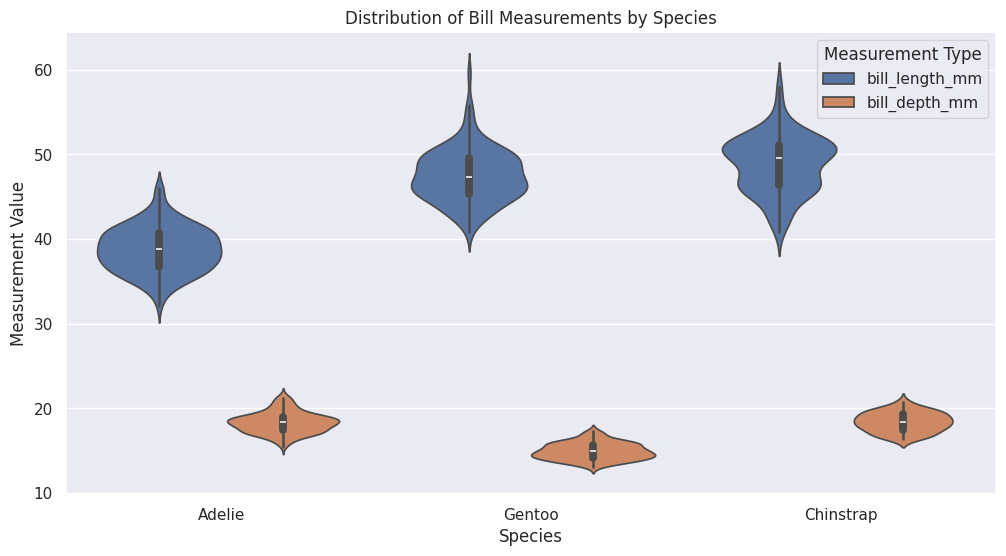

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_long, x="species", y="value", hue="variable")
plt.title("Distribution of Bill Measurements by Species")
plt.xlabel("Species")
plt.ylabel("Measurement Value")
plt.legend(title="Measurement Type")
plt.show()
sns.despine()

Going from wide to long format involves creating one-to-many relationships: the column name is now represented many times in the variable column.

Alternatively, going from long to wide format involves creating many-to-one relationships. As a result, you need to also specify an 'aggregate_function' to tell Polars what to do with duplicates.

In [ ]:
df.pivot(on="species", # will become the column values
         index="sex", # will become the row values
         values="body_mass_kg", # will become the values in the pivot table 
         aggregate_function="max")

sex,Adelie,Gentoo,Chinstrap
str,f64,f64,f64
"""male""",4.775,6.3,4.8
"""female""",3.9,5.2,4.15
null,4.25,4.875,null


Problem: confirm with command we learned above that the max body_mass_kg for a male Adelie is that value

In [43]:
# exercise, confirm this for Gentoo
df.filter(
    (pl.col("species") == "Adelie")
    ).select(pl.col("body_mass_kg")
    .max()
    )
# or
df.select(
    pl.col("body_mass_kg")
    .filter(pl.col("species") == "Adelie")
    .max()

    
)

body_mass_kg
f64
4.775


In [47]:
# convert back to wide format, but this fails becaue you don't know which bill length+depth go together for each individual
df_long.pivot(on="variable",
            index=["species", "island"],
            values="value",
            aggregate_function="first") # looking at the options available, this seems most appropriate?

species,island,bill_length_mm,bill_depth_mm
str,str,f64,f64
"""Adelie""","""Torgersen""",39.1,18.7
"""Adelie""","""Biscoe""",37.8,18.3
"""Adelie""","""Dream""",39.5,16.7
"""Gentoo""","""Biscoe""",46.1,13.2
"""Chinstrap""","""Dream""",46.5,17.9


In [51]:
# Redo, preserving penguin ID
# go from wide to long format
df_long2 = (df
            .select("species", "island", "bill_length_mm", "bill_depth_mm")
            .with_row_index("penguin_id")
            .unpivot(["bill_length_mm", "bill_depth_mm"],
                index=["species", "island", "penguin_id"])
)
df_long2

species,island,penguin_id,variable,value
str,str,u32,str,f64
"""Adelie""","""Torgersen""",0,"""bill_length_mm""",39.1
"""Adelie""","""Torgersen""",1,"""bill_length_mm""",39.5
"""Adelie""","""Torgersen""",2,"""bill_length_mm""",40.3
"""Adelie""","""Torgersen""",3,"""bill_length_mm""",null
"""Adelie""","""Torgersen""",4,"""bill_length_mm""",36.7
…,…,…,…,…
"""Chinstrap""","""Dream""",339,"""bill_depth_mm""",19.8
"""Chinstrap""","""Dream""",340,"""bill_depth_mm""",18.1
"""Chinstrap""","""Dream""",341,"""bill_depth_mm""",18.2


In [52]:
# Now we can successfully go back to wide format
df_long2.pivot(on="variable",
            index=["species", "island", "penguin_id"],
            values="value",
            aggregate_function="first")

species,island,penguin_id,bill_length_mm,bill_depth_mm
str,str,u32,f64,f64
"""Adelie""","""Torgersen""",0,39.1,18.7
"""Adelie""","""Torgersen""",1,39.5,17.4
"""Adelie""","""Torgersen""",2,40.3,18.0
"""Adelie""","""Torgersen""",3,null,null
"""Adelie""","""Torgersen""",4,36.7,19.3
…,…,…,…,…
"""Chinstrap""","""Dream""",339,55.8,19.8
"""Chinstrap""","""Dream""",340,43.5,18.1
"""Chinstrap""","""Dream""",341,49.6,18.2


# Lazy frames
For exploratory data analyses, use DataFrames. For performance, use LazyFrames.

Syntax same as before, but results not immediately available. Need to use `.collect()`.

To load in a LazyFrame, either convert an existing DataFrame or use one of the `.scan_*()` methods

In [ ]:
df_lazy = pl.LazyFrame(df)
# df_lazy = df.lazy()
df_lazy
# note: methods like df_lazy.head() now behave differenlty

In [ ]:
kg_expr = (pl.col("body_mass_g") / 1000).alias("body_mass_kg")
gentoo_male_expr = (pl.col("species") == "Gentoo") , (pl.col("sex") == "male")

# make lazy query that gets the body mass in kg for Gentoo males
lazy_query = (
    df_lazy.with_columns(kg_expr)
    .filter(gentoo_male_expr)
    .select("body_mass_kg")
)

# returns another lazy frame
lazy_query

This lazy query, which hasn't been optimized, is read from the bottom up. 

$\pi$ stands for PROJECTION and refers to columns. We start with all 10 columns and end up with 1. 

Contexts are listed in the same order as written in our query.

Let's compare this to the optimized query plan below.

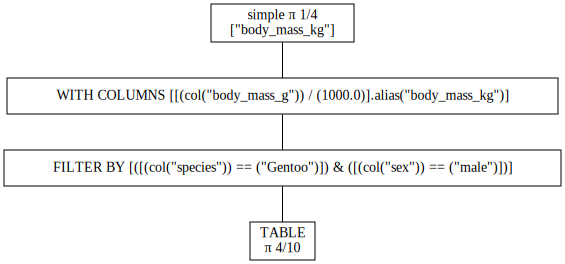

In [ ]:
lazy_query.show_graph()

Polars uses predicate and projection pushdown, database optimization techniques, to make the selection of columns (projection) and the filtering of rows (predicate) as early as possible so that it only loads the data you need.

You can also use `.explain()` to get a string representation of the query plan (useful if text gets truncated within graph nodes).

In [ ]:
lazy_query.explain()

'simple π 1/1 ["body_mass_kg"]\n   WITH_COLUMNS:\n   [[(col("body_mass_g")) / (1000.0)].alias("body_mass_kg")] \n    FILTER [([(col("sex")) == ("male")]) & ([(col("species")) == ("Gentoo")])]\n    FROM\n      DF ["species", "island", "bill_length_mm", "bill_depth_mm", ...]; PROJECT["body_mass_kg", "sex", "species", "body_mass_g"] 4/10 COLUMNS'

In [19]:
# returns a regular polars data frame, not a lazy frame
query_results = lazy_query.collect()
print(type(lazy_query))
print(type(query_results))

<class 'polars.lazyframe.frame.LazyFrame'>
<class 'polars.dataframe.frame.DataFrame'>


In [20]:
query_results.describe()

statistic,body_mass_kg
str,f64
"""count""",61.0
"""null_count""",0.0
"""mean""",5.484836
"""std""",0.313159
"""min""",4.75
"""25%""",5.3
"""50%""",5.5
"""75%""",5.7
"""max""",6.3


# Streaming

Default is to analyze all the data in memory. For streaming the data in batches, just specify as an argument in .collect()

In [21]:
lazy_query.collect(engine="streaming")

body_mass_kg
f64
5.7
5.7
5.4
5.2
5.15
…
5.5
5.85
6.0


# Advanced
## Loading multiple MySQL tables into Polars

In [ ]:
# !pip install connectorx
from urllib.parse import quote
from getpass import getpass

user = "barnold"
pswd = quote(getpass('Database password: ')) # Prompt user for password; don't store in code. Use quote() to encode special characters in passwords
server = "at-database3.stanford.edu"
port = 3306
database = "enigma_acq"
tables = ["sessions", "stimulation", "behavior_traces"]


uri = f"mysql://{user}:{pswd}@{server}:{port}/{database}" 
dfs = {}
for table in tables:
    query = f"SELECT * FROM {table}"
    dfs[table] = pl.read_database_uri(query=query, uri=uri)

dfs['sessions']

subject_id,setup,session_start_time,session_stop_time,experimenter,session_path,session_datetime,hammer,recording_software
i64,i64,i64,i64,str,str,datetime[μs],bool,str
0,1,3823382878158,3823382886081,"""Yang""","""/raw/Testing/2025-02-25_18-47-56""",2025-02-25 18:47:58,false,"""Acquisition2.0"""
0,1,3823383008327,0,"""Yang""","""/raw/Testing/2025-02-25_18-50-06""",2025-02-25 18:50:08,false,"""Acquisition2.0"""
0,1,3823383202517,3823383202624,"""Yang""","""/raw/Testing/2025-02-25_18-53-22""",2025-02-25 18:53:22,false,"""Acquisition2.0"""
0,1,3823383216880,3823383228390,"""Yang""","""/raw/Testing/2025-02-25_18-53-36""",2025-02-25 18:53:36,false,"""Acquisition2.0"""
0,1,3823383277795,3823383379143,"""Yang""","""/raw/Testing/2025-02-25_18-54-37""",2025-02-25 18:54:37,false,"""Acquisition2.0"""
…,…,…,…,…,…,…,…,…
37,1,3838392850052,3838403772921,"""Hannah""","""/raw/Goliath/2025-08-18_13-14-09""",2025-08-18 13:14:10,false,"""Acquisition2.0"""
37,2,3827159280718,3827160327303,"""Jo""","""/raw/Goliath/2025-04-10_12-48-00""",2025-04-10 12:48:00,false,"""Acquisition2.0"""
37,2,3827160514710,3827170603544,"""Jo""","""/raw/Goliath/2025-04-10_13-08-34""",2025-04-10 13:08:34,false,"""Acquisition2.0"""


# Advanced: conditional assignment with window function

When multiple .when().then() statementes are used, Polars only considers a replacement expression that is deeper in the chain if the previous ones (predicates) all failed for that value.

In [ ]:
# in separate pieces

quantiles = (
   df.group_by(["species"]).agg(
        pl.col("swim_score").quantile(0.25).alias("q1_swim_score"),
        pl.col("swim_score").quantile(0.5).alias("q2_swim_score"),
        pl.col("swim_score").quantile(0.75).alias("q3_swim_score"),
    )
)
df_w_quant = df.join(quantiles, on="species")
df_w_quant = df_w_quant.with_columns(
    pl.when(pl.col("swim_score") <= pl.col("q1_swim_score"))
    .then(pl.lit("slow")) # need pl.lit() otherwise Polars treats it as a column
    .when(pl.col("swim_score") <= pl.col("q2_swim_score"))
    .then(pl.lit("intermediate"))
    .when(pl.col("swim_score") <= pl.col("q3_swim_score"))
    .then(pl.lit("fast"))
    .otherwise(pl.lit("really_fast"))
    .alias("swim_score_category")
).select(
    "species", "swim_score", "swim_score_category"
).sort(by="species")

df_w_quant.sample(10)


species,swim_score,swim_score_category
str,f64,str
"""Adelie""",52.715232,"""fast"""
"""Gentoo""",42.285714,"""intermediate"""
"""Adelie""",64.482759,"""really_fast"""
"""Gentoo""",45.957447,"""really_fast"""
"""Chinstrap""",58.4375,"""really_fast"""
"""Adelie""",52.394366,"""fast"""
"""Adelie""",44.318182,"""slow"""
"""Adelie""",55.942029,"""fast"""
"""Gentoo""",38.0,"""slow"""


In [ ]:
# in a single step, using windows functions
df_categorized = df.with_columns(
    pl.col("swim_score").quantile(0.25).over("species").alias("q1"),
    pl.col("swim_score").quantile(0.5).over("species").alias("q2"), 
    pl.col("swim_score").quantile(0.75).over("species").alias("q3"),
).with_columns(
    pl.when(pl.col("swim_score") <= pl.col("q1"))
    .then(pl.lit("slow"))
    .when(pl.col("swim_score") <= pl.col("q2"))
    .then(pl.lit("intermediate"))
    .when(pl.col("swim_score") <= pl.col("q3"))
    .then(pl.lit("fast"))
    .otherwise(pl.lit("really_fast"))
    .alias("swim_score_category")
).drop(["q1", "q2", "q3"])  # Remove temporary quantile columns
df_categorized

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,body_mass_kg,swim_score,swim_score_category
str,str,f64,f64,f64,f64,str,i64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""male""",2007,3.75,48.266667,"""intermediate"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""female""",2007,3.8,48.947368,"""intermediate"""
"""Adelie""","""Torgersen""",40.3,18.0,195.0,3250.0,"""female""",2007,3.25,60.0,"""really_fast"""
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null,null,"""really_fast"""
"""Adelie""","""Torgersen""",36.7,19.3,193.0,3450.0,"""female""",2007,3.45,55.942029,"""fast"""
…,…,…,…,…,…,…,…,…,…,…
"""Chinstrap""","""Dream""",55.8,19.8,207.0,4000.0,"""male""",2009,4.0,51.75,"""intermediate"""
"""Chinstrap""","""Dream""",43.5,18.1,202.0,3400.0,"""female""",2009,3.4,59.411765,"""really_fast"""
"""Chinstrap""","""Dream""",49.6,18.2,193.0,3775.0,"""male""",2009,3.775,51.125828,"""intermediate"""


In [24]:
df_w_quant = df_w_quant.with_columns(
    pl.when(pl.col("swim_score") <= pl.col("q1_swim_score"))
    .then("slow")
    .when(pl.col("swim_score") <= pl.col("q3_swim_score"))
    .then("intermediate")
    .otherwise("fast")
    .alias("swim_score_category")
)

ColumnNotFoundError: unable to find column "slow"; valid columns: ["species", "island", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex", "year", "body_mass_kg", "swim_score", "q1_swim_score", "q2_swim_score", "q3_swim_score", "max_swim_score"]

In [ ]:
# for each species, using only males, get the percentile of body mass for each individual, write a contidional that assigns categorical values based on quantile
# pipeline:
# make kg column
# filter for males
# aggregate by species and compute quantiles
# join back to original
# classify each individual based on quantile

df = df.with_columns(
    (pl.col("body_mass_g") / 1000).alias("body_mass_kg")
)
df

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,body_mass_kg
str,str,f64,f64,f64,f64,str,i64,f64
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""male""",2007,3.75
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""female""",2007,3.8
"""Adelie""","""Torgersen""",40.3,18.0,195.0,3250.0,"""female""",2007,3.25
"""Adelie""","""Torgersen""",null,null,null,null,null,2007,null
"""Adelie""","""Torgersen""",36.7,19.3,193.0,3450.0,"""female""",2007,3.45
…,…,…,…,…,…,…,…,…
"""Chinstrap""","""Dream""",55.8,19.8,207.0,4000.0,"""male""",2009,4.0
"""Chinstrap""","""Dream""",43.5,18.1,202.0,3400.0,"""female""",2009,3.4
"""Chinstrap""","""Dream""",49.6,18.2,193.0,3775.0,"""male""",2009,3.775


species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,body_mass_kg,q1_body_mass_kg,q2_body_mass_kg,q3_body_mass_kg
str,str,f64,f64,f64,f64,str,i64,f64,f64,f64,f64
"""Gentoo""","""Biscoe""",46.1,13.2,211.0,4500.0,"""female""",2007,4.5,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",50.0,16.3,230.0,5700.0,"""male""",2007,5.7,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",48.7,14.1,210.0,4450.0,"""female""",2007,4.45,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",50.0,15.2,218.0,5700.0,"""male""",2007,5.7,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",47.6,14.5,215.0,5400.0,"""male""",2007,5.4,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",46.5,13.5,210.0,4550.0,"""female""",2007,4.55,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",45.4,14.6,211.0,4800.0,"""female""",2007,4.8,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",46.7,15.3,219.0,5200.0,"""male""",2007,5.2,5.3,5.5,5.7
"""Gentoo""","""Biscoe""",43.3,13.4,209.0,4400.0,"""female""",2007,4.4,5.3,5.5,5.7


In [ ]:
kg_col = (pl.col("body_mass_g") / 1000).alias("body_mass_kg")
gentoo_male = (pl.col("species") == "Gentoo") & (pl.col("sex") == "male")

lazy_query = (
    df_lazy.with_columns(kg_col)
    .filter(pl.col(""))
    .select("body_mass_kg")
)
# returns another lazy frame